# GBIF 종 출현 자료 기반 공간 히트맵 분석 실습

GBIF(Global Biodiversity Information Facility)에서 특정 종의 출현 데이터를 불러와 간단한 빙식의 시각화를 수행하는 실습 예제입니다.

주요 내용은 다음과 같습니다.

- GBIF API를 이용한 종 출현 데이터 수집
- GeoPandas를 활용한 GeoDataFrame 생성 및 GPKG 저장
- matplotlib을 이용한 산점도 작성
- leafmap을 활용한 인터랙티브 히트맵 시각화

예제 종으로는 도미니카공화국(DO)에서 관찰된 **황금제비(*Tachycineta euchrysea*)**를 사용합니다.  
다른 종으로 쉽게 교체할 수 있으며, GBIF API 호출 함수를 사용해 가능한 모든 좌표 데이터를 수집한 뒤 공간 패턴을 분석할 수 있습니다.

In [1]:
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import leafmap.foliumap as leafmap

from shapely.geometry import Point

## GBIF API 함수 정의

In [2]:
def get_gbif_species_data(species_name, country_code, max_records=5000):
    base_url = "https://api.gbif.org/v1/occurrence/search"
    limit = 300
    offset = 0
    all_results = []
    total_available = None

    while True:
        params = {
            "scientificName": species_name,
            "country": country_code,
            "hasCoordinate": "true",
            "basisOfRecord": "HUMAN_OBSERVATION",
            "limit": limit,
            "offset": offset,
        }

        r = requests.get(base_url, params=params)
        r.raise_for_status()
        data = r.json()

        if total_available is None:
            total_available = data.get("count", None)
            print(f"[INFO] GBIF total count = {total_available}")

        results = data.get("results", [])
        if not results:
            break

        all_results.extend(results)

        if len(all_results) >= max_records:
            break
        if len(results) < limit:
            break

        offset += limit

    print(f"[INFO] 최종 수집 레코드 수 = {len(all_results)}")

    return pd.json_normalize(all_results) if all_results else pd.DataFrame()

## 특정 종(황금제비) 출현 데이터 조회

- 학명(`species_name`)과 국가 코드(`country_code`)를 설정
- 앞서 정의한 함수로 GBIF 데이터를 가져와 `df_raw`에 저장

In [3]:
# 황금제비 학명과 도미니카공화국 국가 코드
species_name = "Tachycineta euchrysea"
country_code = "DO"  # Dominican Republic

# GBIF에서 데이터 가져오기
df_raw = get_gbif_species_data(species_name, country_code)

[INFO] GBIF total count = 1451
[INFO] 최종 수집 레코드 수 = 1451


## GPKG 파일로 저장

GeoDataFrame을 GeoPackage 파일(`.gpkg`)로 저장하는 함수를 정의하고 실제 파일로 저장합니다.

In [4]:
# GBIF → GeoDataFrame 변환
gdf = gpd.GeoDataFrame(
    df_raw,
    geometry=gpd.points_from_xy(
        df_raw["decimalLongitude"],
        df_raw["decimalLatitude"]
    ),
    crs="EPSG:4326"
)

# GPKG 저장 함수
def save_gpkg(gdf, out_file):
    gdf.to_file(out_file, driver="GPKG")
    print(f"[INFO] GPKG 저장 완료: {out_file}")

# 저장 파일명
out_file = "gbif_tachycineta_euchrysea.gpkg"

# 함수 호출
save_gpkg(gdf, out_file)

[INFO] GPKG 저장 완료: gbif_tachycineta_euchrysea.gpkg


In [5]:
# 다시 읽기
gdf = gpd.read_file(out_file)

# head 확인
gdf.head()

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,nomenclaturalCode,fieldNotes,verbatimElevation,behavior,higherClassification,extensions.http://rs.tdwg.org/ac/terms/Multimedia,occurrenceRemarks,associatedTaxa,distanceFromCentroidInMeters,geometry
0,5313210987,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,7182d304-b0a2-404b-baba-2086a325c221,e2e717bf-551a-4917-bdc9-4fa0f342c530,DO,DWC_ARCHIVE,2025-10-29T11:02:38.172+00:00,2025-11-05T07:38:23.004+00:00,24,...,None,None,None,None,None,None,None,None,NaN,POINT (-71.69899 18.30019)
1,5316763961,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,7182d304-b0a2-404b-baba-2086a325c221,e2e717bf-551a-4917-bdc9-4fa0f342c530,DO,DWC_ARCHIVE,2025-10-29T11:02:38.172+00:00,2025-11-05T07:40:40.373+00:00,24,...,None,None,None,None,None,None,None,None,NaN,POINT (-71.69899 18.30019)
2,5365862328,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,7182d304-b0a2-404b-baba-2086a325c221,e2e717bf-551a-4917-bdc9-4fa0f342c530,DO,DWC_ARCHIVE,2025-10-29T11:02:38.172+00:00,2025-11-05T07:46:00.626+00:00,24,...,None,None,None,None,None,None,None,None,NaN,POINT (-71.6988 18.30823)
3,5385270029,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,7182d304-b0a2-404b-baba-2086a325c221,e2e717bf-551a-4917-bdc9-4fa0f342c530,DO,DWC_ARCHIVE,2025-10-29T11:02:38.172+00:00,2025-11-05T07:42:24.171+00:00,24,...,None,None,None,None,None,None,None,None,NaN,POINT (-71.69899 18.30019)
4,5388599924,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,7182d304-b0a2-404b-baba-2086a325c221,e2e717bf-551a-4917-bdc9-4fa0f342c530,DO,DWC_ARCHIVE,2025-10-29T11:02:38.172+00:00,2025-11-05T07:39:02.891+00:00,24,...,None,None,None,None,None,None,None,None,NaN,POINT (-71.70744 18.31246)


## 산점도 시각화

GeoDataFrame에서 경·위도(lon, lat)를 추출하여 matplotlib 산점도(Scatter plot)로 공간 분포를 확인합니다.

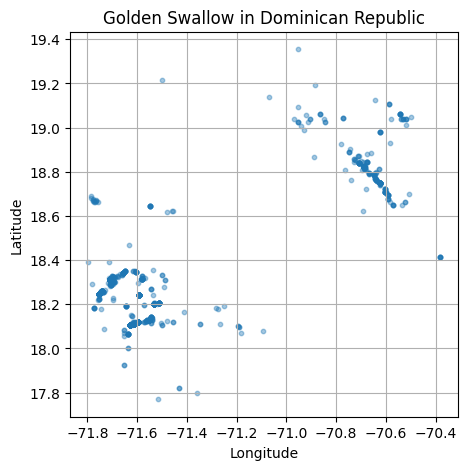

In [6]:
# geometry에서 lon/lat 추출
gdf["lon"] = gdf.geometry.x
gdf["lat"] = gdf.geometry.y

plt.figure(figsize=(5, 5))
plt.scatter(gdf["lon"], gdf["lat"], alpha=0.4, s=10)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Golden Swallow in Dominican Republic")
plt.grid(True)
plt.show()

## leafmap 기반 인터랙티브 Heatmap 생성

leafmap은 folium 또는 ipyleaflet 기반의 지도 위젯을 제공하며 CSV 파일 기반으로 히트맵을 그릴 수 있습니다.

In [7]:
m = leafmap.Map(width="700px", height="400px")
m

In [8]:
m = leafmap.Map(width="700px", height="400px")
m.add_basemap("HYBRID")
m

In [9]:
m = leafmap.Map(width="700px", height="400px")
m.add_tile_layer(
    url="https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}",
    name="Google Satellite",
    attribution="Google",
)
m

In [10]:
# leafmap.add_heatmap용 CSV 저장
filepath = "golden_swallow_do_heatmap.csv"
gdf["lon"] = gdf.geometry.x
gdf["lat"] = gdf.geometry.y
gdf["weight"] = 1
gdf[["lat", "lon", "weight"]].to_csv(filepath, index=False)

# 지도 중심은 관측치 평균 위치로
center_lon = gdf["lon"].mean()
center_lat = gdf["lat"].mean()

# leafmap 히트맵
m = leafmap.Map(width="700px", height="400px", center=[center_lat, center_lon], zoom=7)
m.add_heatmap(
    filepath,
    latitude="lat",
    longitude="lon",
    value="weight",
    name="Golden Swallow heat map",
    radius=20,
)
m